In [111]:
require(data.table)
require(impute)
require(tidyverse)
require(minfi)
require(Gviz)
require(missMethyl)
require(limma)
require(seqlm)
require(sva)
require(gprofiler2)
require(GOsummaries)
require(ggplot2)
require(gridExtra)
require(ggpubr)
require('clusterProfiler')

In [112]:
load("sig_cd8.RData")
load("sig_cd4.RData")

In [115]:
nrow(cd8_mat)
nrow(cd4_mat)

[1] 1861

[1] 44

In [120]:
length(intersect(rownames(cd4_mat), rownames(cd8_mat)))

[1] 32

# CD8

# TOP5

In [121]:
cd8_top5 <- cd8_mat[cd8_cpg$probes[1:5],]

In [122]:
cd8_top5 <- as.data.frame(t(cd8_top5))
colnames(cd8_top5) <- c(cd8_cpg$probes[1:5])
cd8_geo_top5 <- rownames(cd8_top5)
cd8_top5 <- cd8_top5 %>% mutate("geo" = cd8_geo_top5) 
cd8_top5_key <- cd8_key %>% filter(geo %in% cd8_geo_top5)
head(cd8_top5_key)

sample,title,age,cell_type,diagnosis,geo
68,gDNA_CD8_Control_rep1,54,CD8 T cells,Healthy,GSM1848063
69,gDNA_CD8_Control_rep2,37,CD8 T cells,Healthy,GSM1848065
70,gDNA_CD8_Control_rep3,38,CD8 T cells,Healthy,GSM1848068
71,gDNA_CD8_Control_rep4,49,CD8 T cells,Healthy,GSM1848070
72,gDNA_CD8_Control_rep5,37,CD8 T cells,Healthy,GSM1848071
73,gDNA_CD8_Control_rep6,51,CD8 T cells,Healthy,GSM1848072


In [123]:
cd8_top5 <- cd8_top5 %>%
    mutate("cell_type" = cd8_top5_key$cell_type,
           "diagnosis" = cd8_top5_key$diagnosis)

In [124]:
cd8_top5_cpg <- cd8_cpg[1:5,] 
levels(droplevels((cd8_top5_cpg$UCSC_RefGene_Name)))

[1] "APBB2"   "MAL2"    "RIN3"    "SEPT9"   "TMEM55A"

In [125]:
colnames(cd8_top5)[1:5] = levels(droplevels((cd8_top5_cpg$UCSC_RefGene_Name)))

In [126]:
head(cd8_top5)

APBB2,MAL2,RIN3,SEPT9,TMEM55A,geo,cell_type,diagnosis
0.5522365,0.6719406,0.5439589,0.6325498,0.7856264,GSM1848063,CD8 T cells,Healthy
0.5785091,0.7894404,0.5872215,0.4864225,0.8588831,GSM1848065,CD8 T cells,Healthy
0.6408691,0.7468551,0.6002372,0.5089860,0.8636725,GSM1848068,CD8 T cells,Healthy
0.6721345,0.7405998,0.5409605,0.5146971,0.8540408,GSM1848070,CD8 T cells,Healthy
0.6499170,0.7406536,0.5054517,0.5283667,0.8873986,GSM1848071,CD8 T cells,Healthy
0.7297605,0.7925555,0.5323719,0.4021034,0.8825603,GSM1848072,CD8 T cells,Healthy


In [127]:
cd8_top5 <- as.data.frame(cd8_top5) %>% gather("sample", "value", -cell_type, -geo, -diagnosis)

In [128]:
head(cd8_top5)

geo,cell_type,diagnosis,sample,value
GSM1848063,CD8 T cells,Healthy,APBB2,0.5522365
GSM1848065,CD8 T cells,Healthy,APBB2,0.5785091
GSM1848068,CD8 T cells,Healthy,APBB2,0.6408691
GSM1848070,CD8 T cells,Healthy,APBB2,0.6721345
GSM1848071,CD8 T cells,Healthy,APBB2,0.6499170
GSM1848072,CD8 T cells,Healthy,APBB2,0.7297605


In [129]:
cd8_top5$value <- as.numeric(cd8_top5$value)

In [130]:
cd8_top5_plot <- ggplot(cd8_top5, aes(x=sample, y=value, fill=factor(diagnosis))) +
    geom_boxplot() + facet_grid(~sample, scales="free", space="free_y") +
    labs(title = "CD8+ T cells")

# HISTOGRAMS

In [131]:
cd8_healthy_geo <- filter(cd8_key, diagnosis == 'Healthy')$geo
cd8_graves_geo <- filter(cd8_key, diagnosis != 'Healthy')$geo

cd8_healthy_key <- filter(cd8_key, diagnosis == 'Healthy')
cd8_graves_key <- filter(cd8_key, diagnosis != 'Healthy')

In [132]:
cd8_healthy <- cd8_mat %>% select(cd8_healthy_geo)
cd8_graves <- cd8_mat %>% select(cd8_graves_geo)

In [133]:
cd8_healthy <- as.data.frame(t(cd8_healthy))
cd8_healthy <- cd8_healthy %>% mutate("geo" = cd8_healthy_geo,
                                      "diagnosis" = cd8_healthy_key$diagnosis)


In [134]:
cd8_graves <- as.data.frame(t(cd8_graves))
cd8_graves <- cd8_graves %>% mutate("geo" = cd8_graves_geo,
                                      "diagnosis" = cd8_graves_key$diagnosis)


In [135]:
cd8_healthy_gathered <- as.data.frame(cd8_healthy) %>% gather("sample", "value",  -geo, -diagnosis)
cd8_graves_gathered <- as.data.frame(cd8_graves) %>% gather("sample", "value", -geo, -diagnosis)

In [136]:
cd8_healthy_hist <- ggplot(cd8_healthy_gathered, aes(x=value)) + 
    geom_histogram(color="black", fill="white") +
    labs(title="CD8: Control patients")

cd8_graves_hist <- ggplot(cd8_graves_gathered, aes(x=value)) + 
    geom_histogram(color="black", fill="white") +
    labs(title="CD8: Graves' disease patients")

# GO ANNOTATION

In [137]:
i <- cd8_healthy_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))
j <- cd8_graves_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))


cd8_hyper <- i %>% filter(mean < j$mean) %>% select(sample)
cd8_hypo <- i %>% filter(mean > j$mean) %>% select(sample)


In [138]:
nrow(cd8_hyper)
nrow(cd8_hypo)

[1] 568

[1] 1293

In [139]:
cd8_hypo_cpg <- cd8_cpg %>%
    filter(probes %in% cd8_hypo$sample) %>%
    select(UCSC_RefGene_Name)

cd8_hyper_cpg <- cd8_cpg %>%
    filter(probes %in% cd8_hyper$sample) %>%
    select(UCSC_RefGene_Name)

In [140]:
cd8_hypo_go <- gconvert(cd8_hypo_cpg$UCSC_RefGene_Name,
               target = "uniprotswissprot")$target
cd8_hyper_go <- gconvert(cd8_hyper_cpg$UCSC_RefGene_Name,
               target = "uniprotswissprot")$target

head(cd8_hypo_go)

cd8_hypo_gost <- gost(cd8_hypo_go)
cd8_hyper_gost <- gost(cd8_hyper_go)

[1] "Q8TB24" "Q9UHD8" "Q92870" "O60292" "P58400" "Q9ULB1"

In [141]:
head(cd8_hypo_gost$result)
head(cd8_hyper_gost$result)

cd8_hyper_gost_result <- cd8_hyper_gost$result %>% arrange(p_value)
cd8_hyper_gost_result <- cd8_hyper_gost_result[1:10, ] %>% arrange(intersection_size)

query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
query_1,TRUE,4.961894e-02,3,183,3,0.01639344,1.00000000,CORUM:6928,CORUM,ARHGEF7-GIT2-PAK1 complex,3631,2466,CORUM:0000000
query_1,TRUE,1.010355e-08,1296,666,99,0.14864865,0.07638889,GO:0045321,GO:BP,leukocyte activation,17847,13426,"GO:0002376, GO:0001775"
query_1,TRUE,2.846800e-08,653,666,62,0.09309309,0.09494640,GO:0002274,GO:BP,myeloid leukocyte activation,17847,945,GO:0045321
query_1,TRUE,6.398274e-08,1455,666,105,0.15765766,0.07216495,GO:0001775,GO:BP,cell activation,17847,568,GO:0009987
query_1,TRUE,5.482015e-07,1273,666,93,0.13963964,0.07305577,GO:0002252,GO:BP,immune effector process,17847,923,GO:0002376
query_1,TRUE,1.335024e-06,498,666,49,0.07357357,0.09839357,GO:0002446,GO:BP,neutrophil mediated immunity,17847,1117,GO:0002444


query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
query_1,TRUE,1.529136e-19,470,264,44,0.16666667,0.09361702,GO:0042110,GO:BP,T cell activation,17847,11669,GO:0046649
query_1,TRUE,2.885160e-16,744,264,50,0.18939394,0.06720430,GO:0046649,GO:BP,lymphocyte activation,17847,14571,GO:0045321
query_1,TRUE,1.990654e-14,140,264,23,0.08712121,0.16428571,GO:0046631,GO:BP,alpha-beta T cell activation,17847,14553,GO:0042110
query_1,TRUE,1.239562e-12,3214,264,103,0.39015152,0.03204729,GO:0002376,GO:BP,immune system process,17847,1047,GO:0008150
query_1,TRUE,2.474203e-12,1455,264,64,0.24242424,0.04398625,GO:0001775,GO:BP,cell activation,17847,568,GO:0009987
query_1,TRUE,9.418972e-12,1296,264,59,0.22348485,0.04552469,GO:0045321,GO:BP,leukocyte activation,17847,13426,"GO:0002376, GO:0001775"


In [142]:
png(filename="cd8_functional3.png", res=300, units="in", width=8, height=5)
ggplot(cd8_hyper_gost_result, aes(x=reorder(term_name, -intersection_size), y=intersection_size, fill=p_value)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    scale_fill_continuous(low="blue", high="red") +
    labs(title = "Functional characterization of differentially methylated sites",
         subtitle = "CD8+ T cells, hypermethylated",
         x = "Gene ontology terms", y = "Intersection sizes")
dev.off()

png 
  2

# CD4

# TOP5

In [143]:
cd4_top5 <- cd4_mat[cd4_cpg$probes[1:5],]
head(cd4_top5)

,GSM1847992,GSM1847993,GSM1847994,GSM1847995,GSM1847996,GSM1847997,GSM1847998,GSM1847999,GSM1848000,GSM1848001,...,GSM1848049,GSM1848050,GSM1848051,GSM1848052,GSM1848053,GSM1848054,GSM1848055,GSM1848056,GSM1848057,GSM1848060
cg07418892,0.3746188,0.3973541,0.4893164,0.3623600,0.3904227,0.2790231,0.4380088,0.3876601,0.3378170,0.3664634,...,0.5540782,0.4730239,0.5020737,0.5610653,0.4792795,0.4678891,0.5043112,0.4691209,0.5015271,0.5399349
cg14339466,0.3118346,0.4007610,0.4041487,0.3125327,0.3937488,0.2931638,0.3734629,0.3486088,0.3453136,0.3410663,...,0.5137801,0.4320967,0.4301446,0.5139158,0.4795576,0.4275743,0.4871791,0.4000400,0.4309430,0.4422882
cg27666046,0.2000737,0.1910964,0.3308640,0.2949468,0.2846265,0.1809921,0.4114654,0.2862912,0.2974187,0.2340255,...,0.5153853,0.3479376,0.4077258,0.4697500,0.4203842,0.3831982,0.4219122,0.3610347,0.3950184,0.3413175
cg18825594,0.3434822,0.2787679,0.3929762,0.3234270,0.3713220,0.1956442,0.3979059,0.3619022,0.2914690,0.2291669,...,0.4508102,0.3977738,0.4756833,0.4993715,0.4158253,0.4198898,0.5017659,0.4050197,0.4521970,0.4795657
cg01673307,0.2949360,0.3058109,0.3127201,0.3085045,0.2382209,0.2137857,0.4432739,0.3081647,0.2591678,0.2784781,...,0.5576611,0.3685801,0.4296107,0.3954151,0.3668905,0.3999512,0.4841656,0.4594781,0.3956058,0.4527579


In [144]:
cd4_top5 <- as.data.frame(t(cd4_top5))
colnames(cd4_top5) <- c(cd4_cpg$probes[1:5])
cd4_geo_top5 <- rownames(cd4_top5)
cd4_top5 <- cd4_top5 %>% mutate("geo" = cd4_geo_top5) 
cd4_top5_key <- cd4_key %>% filter(geo %in% cd4_geo_top5)
head(cd4_top5_key)

sample,title,age,cell_type,diagnosis,geo
1,gDNA_CD4_Control_rep1,54,CD4 T cells,Healthy,GSM1847992
2,gDNA_CD4_Control_rep2,37,CD4 T cells,Healthy,GSM1847993
3,gDNA_CD4_Control_rep3,38,CD4 T cells,Healthy,GSM1847994
4,gDNA_CD4_Control_rep4,49,CD4 T cells,Healthy,GSM1847995
5,gDNA_CD4_Control_rep5,37,CD4 T cells,Healthy,GSM1847996
6,gDNA_CD4_Control_rep6,51,CD4 T cells,Healthy,GSM1847997


In [145]:
cd4_top5 <- cd4_top5 %>%
    mutate("cell_type" = cd4_top5_key$cell_type,
           "diagnosis" = cd4_top5_key$diagnosis)

In [146]:
head(cd4_top5_cpg <- cd4_cpg[1:5,])

seqnames,start,end,width,strand,length,coef,se,tstat,p.value,fdr,bonferroni,UCSC_RefGene_Group,Relation_to_UCSC_CpG_Island,UCSC_RefGene_Name,probes
6,52150456,52150456,1,*,1,-0.1095361,0.01313983,-8.336187,7.385337e-12,8.200459e-10,2.214124e-08,TSS1500,S_Shore,MCM3,cg07418892
13,27927490,27927490,1,*,1,-0.1031197,0.01372436,-7.513627,2.134152e-10,5.927095e-09,6.398189e-07,,,,cg14339466
17,80279077,80279077,1,*,1,-0.1153534,0.01556828,-7.409516,3.265983e-10,7.252902e-09,9.791417e-07,3'UTR,Island,SECTM1,cg27666046
2,10184650,10184650,1,*,1,-0.1018892,0.01375859,-7.405495,3.320083e-10,7.318830e-09,9.953608e-07,Body,Island,KLF11,cg18825594
6,32819911,32819911,1,*,1,-0.1028032,0.01427678,-7.200731,7.658650e-10,1.177904e-08,2.296063e-06,Body,N_Shore,TAP1,cg01673307


In [147]:
cd4_top5_cpg <- cd4_cpg[1:5,] 

In [148]:
head(cd4_top5)

cg07418892,cg14339466,cg27666046,cg18825594,cg01673307,geo,cell_type,diagnosis
0.3746188,0.3118346,0.2000737,0.3434822,0.2949360,GSM1847992,CD4 T cells,Healthy
0.3973541,0.4007610,0.1910964,0.2787679,0.3058109,GSM1847993,CD4 T cells,Healthy
0.4893164,0.4041487,0.3308640,0.3929762,0.3127201,GSM1847994,CD4 T cells,Healthy
0.3623600,0.3125327,0.2949468,0.3234270,0.3085045,GSM1847995,CD4 T cells,Healthy
0.3904227,0.3937488,0.2846265,0.3713220,0.2382209,GSM1847996,CD4 T cells,Healthy
0.2790231,0.2931638,0.1809921,0.1956442,0.2137857,GSM1847997,CD4 T cells,Healthy


In [149]:
cd4_top5 <- as.data.frame(cd4_top5) %>% gather("sample", "value", -cell_type, -geo, -diagnosis)
cd4_top5$value <- as.numeric(cd4_top5$value)

In [150]:
cd4_top5_plot <- ggplot(cd4_top5, aes(x=sample, y=value, fill=factor(diagnosis))) +
    geom_boxplot() + facet_grid(~sample, scales="free", space="free_y") +
    labs(title = "CD4+ T cells")

# Histograms

In [151]:
cd4_healthy_geo <- filter(cd4_key, diagnosis == 'Healthy')$geo
cd4_graves_geo <- filter(cd4_key, diagnosis != 'Healthy')$geo

cd4_healthy_key <- filter(cd4_key, diagnosis == 'Healthy')
cd4_graves_key <- filter(cd4_key, diagnosis != 'Healthy')

In [152]:
cd4_healthy <- cd4_mat %>% select(cd4_healthy_geo)
cd4_graves <- cd4_mat %>% select(cd4_graves_geo)

In [153]:
cd4_healthy <- as.data.frame(t(cd4_healthy))
cd4_healthy <- cd4_healthy %>% mutate("geo" = cd4_healthy_geo,
                                      "diagnosis" = cd4_healthy_key$diagnosis)


In [154]:
cd4_graves <- as.data.frame(t(cd4_graves))
cd4_graves <- cd4_graves %>% mutate("geo" = cd4_graves_geo,
                                      "diagnosis" = cd4_graves_key$diagnosis)


In [155]:
cd4_healthy_gathered <- as.data.frame(cd4_healthy) %>% gather("sample", "value",  -geo, -diagnosis)
cd4_graves_gathered <- as.data.frame(cd4_graves) %>% gather("sample", "value", -geo, -diagnosis)

In [156]:
head(cd4_healthy_gathered)

geo,diagnosis,sample,value
GSM1847992,Healthy,cg00142257,0.4122434
GSM1847993,Healthy,cg00142257,0.5184848
GSM1847994,Healthy,cg00142257,0.5627227
GSM1847995,Healthy,cg00142257,0.4864585
GSM1847996,Healthy,cg00142257,0.4313295
GSM1847997,Healthy,cg00142257,0.4655618


In [157]:
cd4_healthy_hist <- ggplot(cd4_healthy_gathered, aes(x=value)) + 
    geom_histogram(color="black", fill="white") +
    labs(title="CD4: Control patients")

cd4_graves_hist <- ggplot(cd4_graves_gathered, aes(x=value)) + 
    geom_histogram(color="black", fill="white") +
    labs(title="CD4: Graves' disease patients")

# GO annotation

In [160]:
i <- cd4_healthy_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))
j <- cd4_graves_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))


cd4_hyper <- i %>% filter(mean <= j$mean) %>% select(sample)
cd4_hypo <- i %>% filter(mean > j$mean) %>% select(sample)


In [163]:
nrow(cd4_hyper)
nrow(cd4_hypo)

[1] 30

[1] 14

# Differential methylation analysis

In [108]:
png(filename="top5_cpg3.png", res=300, units="in", width=8, height=8)
annotate_figure(ggarrange(cd4_top5_plot,
                          cd8_top5_plot,
                          nrow=2, common.legend=TRUE),
                top = text_grob("Top 5 differentially methylated CpGs", size=20))
dev.off()

png 
  2

In [109]:
png(filename="hist2.png", res=300, units="in", width=8, height=8)
annotate_figure(ggarrange(cd4_healthy_hist,
                          cd4_graves_hist,
                          cd8_healthy_hist,
                          cd8_graves_hist,
                          nrow=2, ncol=2, common.legend=TRUE),
                top = text_grob("Histograms", size=20))
dev.off()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


png 
  2

In [70]:
intersect(cd4_hypo, cd8_hypo)
intersect(cd4_hyper, cd8_hyper)


Warning message:
"Length of logical index must be 1 or 1293, not 0"

<0 x 0 matrix>

Warning message:
"Length of logical index must be 1 or 568, not 0"

<0 x 0 matrix>

# EXPRESSION DATA

In [168]:
load("expr.RData")
length(intersect(rownames(cd8_expr), rownames(cd4_expr)))

[1] 584

# CD8

# GO ANNOTATION

In [165]:
cd8_expr_healthy_geo <- filter(cd8_expr_key, diagnosis == 'Healthy')$geo
cd8_expr_graves_geo <- filter(cd8_expr_key, diagnosis != 'Healthy')$geo

cd8_expr_healthy_key <- filter(cd8_expr_key, diagnosis == 'Healthy')
cd8_expr_graves_key <- filter(cd8_expr_key, diagnosis != 'Healthy')

In [166]:
cd8_expr_healthy <- cd8_expr %>% select(cd8_expr_healthy_geo)
cd8_expr_graves <- cd8_expr %>% select(cd8_expr_graves_geo)

In [169]:
cd8_expr_healthy <- as.data.frame(t(cd8_expr_healthy))
cd8_expr_healthy <- cd8_expr_healthy %>% mutate("geo" = cd8_expr_healthy_geo,
                                      "diagnosis" = cd8_expr_healthy_key$diagnosis)


In [170]:
cd8_expr_graves <- as.data.frame(t(cd8_expr_graves))
cd8_expr_graves <- cd8_expr_graves %>% mutate("geo" = cd8_expr_graves_geo,
                                      "diagnosis" = cd8_expr_graves_key$diagnosis)


In [171]:
cd8_expr_healthy_gathered <- as.data.frame(cd8_expr_healthy) %>% gather("sample", "value",  -geo, -diagnosis)
cd8_expr_graves_gathered <- as.data.frame(cd8_expr_graves) %>% gather("sample", "value", -geo, -diagnosis)

In [172]:
i <- cd8_expr_healthy_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))
j <- cd8_expr_graves_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))


cd8_expr_hyper <- i %>% filter(mean < j$mean) %>% select(sample)
cd8_expr_hypo <- i %>% filter(mean > j$mean) %>% select(sample)


In [173]:
nrow(cd8_expr_hyper)
nrow(cd8_expr_hypo)

[1] 0

[1] 5118

In [174]:
cd8_expr_hypo_gost <- gost(cd8_expr_anno$ILMN_Gene, 
                           sources=c("KEGG", "REAC", "MI"))

In [175]:
head(cd8_expr_hypo_gost$result)

query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
query_1,TRUE,3.004615e-09,134,998,47,0.04709419,0.3507463,KEGG:03010,KEGG,Ribosome,7772,204,KEGG:00000
query_1,TRUE,2.240719e-03,149,998,38,0.03807615,0.2550336,KEGG:04932,KEGG,Non-alcoholic fatty liver disease (NAFLD),7772,365,KEGG:00000
query_1,TRUE,1.609943e-02,191,998,43,0.04308617,0.2251309,KEGG:05016,KEGG,Huntington disease,7772,388,KEGG:00000
query_1,TRUE,2.338380e-02,142,998,34,0.03406814,0.2394366,KEGG:05012,KEGG,Parkinson disease,7772,386,KEGG:00000
query_1,TRUE,1.445504e-13,94,1327,44,0.03315750,0.4680851,REAC:R-HSA-156842,REAC,Eukaryotic Translation Elongation,10565,729,REAC:R-HSA-72766
query_1,TRUE,1.068772e-12,102,1327,45,0.03391108,0.4411765,REAC:R-HSA-72689,REAC,Formation of a pool of free 40S subunits,10565,801,REAC:R-HSA-72737


In [176]:
cd8_expr_hypo_gost_result <- cd8_expr_hypo_gost$result %>% arrange(p_value)
cd8_expr_hypo_gost_result <- cd8_expr_hypo_gost_result[1:10, ] %>% arrange(intersection_size)

In [177]:
cd8_hypo_goplot <- ggplot(cd8_expr_hypo_gost_result, aes(x=reorder(term_name, -intersection_size), y=intersection_size, fill=p_value)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    scale_fill_continuous(low="blue", high="red") +
    labs(subtitle = "CD8+ T cells, downregulated",
         x = "Gene ontology terms", y = "Intersection sizes")

# CD4

# GO ANNOTATION

In [178]:
cd4_expr_healthy_geo <- filter(cd4_expr_key, diagnosis == 'Healthy')$geo
cd4_expr_graves_geo <- filter(cd4_expr_key, diagnosis != 'Healthy')$geo

cd4_expr_healthy_key <- filter(cd4_expr_key, diagnosis == 'Healthy')
cd4_expr_graves_key <- filter(cd4_expr_key, diagnosis != 'Healthy')

In [179]:
cd4_expr_healthy <- cd4_expr %>% select(cd4_expr_healthy_geo)
cd4_expr_graves <- cd4_expr %>% select(cd4_expr_graves_geo)

In [180]:
cd4_expr_healthy <- as.data.frame(t(cd4_expr_healthy))
cd4_expr_healthy <- cd4_expr_healthy %>% mutate("geo" = cd4_expr_healthy_geo,
                                      "diagnosis" = cd4_expr_healthy_key$diagnosis)

cd4_expr_graves <- as.data.frame(t(cd4_expr_graves))
cd4_expr_graves <- cd4_expr_graves %>% mutate("geo" = cd4_expr_graves_geo,
                                      "diagnosis" = cd4_expr_graves_key$diagnosis)


In [181]:
cd4_expr_healthy_gathered <- as.data.frame(cd4_expr_healthy) %>% gather("sample", "value",  -geo, -diagnosis)
cd4_expr_graves_gathered <- as.data.frame(cd4_expr_graves) %>% gather("sample", "value", -geo, -diagnosis)

In [182]:
i <- cd4_expr_healthy_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))
j <- cd4_expr_graves_gathered %>% group_by(sample) %>% summarise("mean" = mean(value))


cd4_expr_hyper <- i %>% filter(mean < j$mean) %>% select(sample)
cd4_expr_hypo <- i %>% filter(mean > j$mean) %>% select(sample)


In [183]:
nrow(cd4_expr_hyper)
nrow(cd4_expr_hypo)

[1] 0

[1] 2909

In [184]:
cd4_expr_hypo_gost <- gost(cd4_expr_anno$ILMN_Gene, 
                           sources=c("KEGG", "REAC", "MI"))

In [185]:
cd4_expr_hypo_gost_result <- cd4_expr_hypo_gost$result %>% arrange(p_value)
cd4_expr_hypo_gost_result <- cd4_expr_hypo_gost_result[1:10, ] %>% arrange(intersection_size)

In [186]:
cd4_hypo_goplot <- ggplot(cd4_expr_hypo_gost_result, aes(x=reorder(term_name, -intersection_size), y=intersection_size, fill=p_value)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    scale_fill_continuous(low="blue", high="red") +
    labs(subtitle = "CD4+ T cells, downregulated genes",
         x = "Gene ontology terms", y = "Intersection sizes")

# GO ANNOTATION

In [187]:
png("expr.png", res=300, units="in", width=8, height=8)
annotate_figure(ggarrange(cd4_hypo_goplot,
                          nrow=1, common.legend=FALSE),
                top = text_grob("Functional characterization of differentially expressed genes", size=16))
dev.off()

png 
  2

# CORRELATION

In [188]:
cd4_meth_genes <- gconvert(cd4_anno$UCSC_RefGene_Accession, target="ILLUMINA_HUMANHT_12_V4")$target
cd4_expr_genes <- cd4_expr_anno$ID
cd4_both <- intersect(cd4_meth_genes, cd4_expr_genes)
cd4_both
length(cd4_both)

[1] "ILMN_1702501" "ILMN_1774733" "ILMN_2415157" "ILMN_1673207" "ILMN_1782983"

[1] 5

In [94]:
cd4_anno_selected <- cd4_anno %>% select(ID, "input"=UCSC_RefGene_Accession) %>% separate_rows(input, sep = ";")
cd4_anno_selected <- gconvert(cd4_anno_selected$input, target="ILLUMINA_HUMANHT_12_V4") %>% 
select(input, target, name) %>% inner_join(cd4_anno_selected) %>% filter(target %in% cd4_both)

Joining, by = "input"

In [95]:
cd4_anno_selected

input,target,name,ID
NM_001006932,ILMN_1702501,RPS6KA2,cg00278517
NM_001006932,ILMN_1702501,RPS6KA2,cg08109681
NM_003745,ILMN_1774733,SOCS1,cg03014241
NM_212481,ILMN_2415157,ARID5A,cg04722215
NM_001006932,ILMN_1702501,RPS6KA2,cg00278517
NM_001006932,ILMN_1702501,RPS6KA2,cg08109681
NM_021135,ILMN_1702501,RPS6KA2,cg08109681
NM_003597,ILMN_1673207,KLF11,cg18825594
NM_003597,ILMN_1782983,KLF11,cg18825594


In [96]:
cd4_expr_both <- as.data.frame(t(cd4_expr))
head(cd4_expr_both %>% select(cd4_anno_selected$target))

cd4_meth_both <- as.data.frame(t(cd4_mat))
cd4_meth_both <- cd4_meth_both %>% select(cd4_anno_selected$ID)

colnames(cd4_meth_both) <- (cd4_anno_selected %>% filter(ID == colnames(cd4_meth_both)) %>%
                           select(target))$target

head(cd4_meth_both)

,ILMN_1702501,ILMN_1774733,ILMN_2415157,ILMN_1673207,ILMN_1782983
GSM1848135,5.274709,6.237749,5.822172,5.812649,4.411962
GSM1848136,4.950417,5.304016,5.188688,5.643818,4.382054
GSM1848137,4.320105,4.575799,4.644114,5.058216,4.413359
GSM1848138,4.317128,7.097592,5.302331,5.505367,5.027821
GSM1848139,5.090345,5.925700,5.835750,5.631124,4.364255
GSM1848140,4.766525,5.499136,5.249782,5.569375,4.475754


Warning message in ID == colnames(cd4_meth_both):
"długość dłuszego obiektu nie jest wielokrotnością długości krótszego obiektu"

,ILMN_1702501,ILMN_1702501,ILMN_1774733,ILMN_2415157,ILMN_1702501
GSM1847992,0.4734909,0.28505674,0.2090005,0.2757364,0.3434822
GSM1847993,0.5687090,0.09896093,0.1178048,0.1767087,0.2787679
GSM1847994,0.5864801,0.28105626,0.2806463,0.3338618,0.3929762
GSM1847995,0.4977508,0.26305208,0.2373052,0.2866298,0.3234270
GSM1847996,0.6137593,0.35970426,0.3001462,0.2412977,0.3713220
GSM1847997,0.5986472,0.24169998,0.2047115,0.1710810,0.1956442


In [97]:
cd4_meth_both_gathered <- as.data.frame(cd4_meth_both) %>% gather("sample", "meth_value")
cd4_expr_both_gathered <- as.data.frame(cd4_expr_both) %>% gather("sample", "expr_value")

In [98]:
head(cd4_meth_both_gathered)
head(cd4_expr_both_gathered)

ILMN_1702501,ILMN_1702501,sample,meth_value
0.28505674,0.3434822,ILMN_1702501,0.4734909
0.09896093,0.2787679,ILMN_1702501,0.5687090
0.28105626,0.3929762,ILMN_1702501,0.5864801
0.26305208,0.3234270,ILMN_1702501,0.4977508
0.35970426,0.3713220,ILMN_1702501,0.6137593
0.24169998,0.1956442,ILMN_1702501,0.5986472


sample,expr_value
ILMN_1651262,8.512601
ILMN_1651262,8.422841
ILMN_1651262,7.859521
ILMN_1651262,8.538718
ILMN_1651262,8.272984
ILMN_1651262,8.291457


In [99]:
cd4_correlation <- cd4_meth_both_gathered[c(-1,-2)] %>% inner_join(cd4_expr_both_gathered)

Joining, by = "sample"

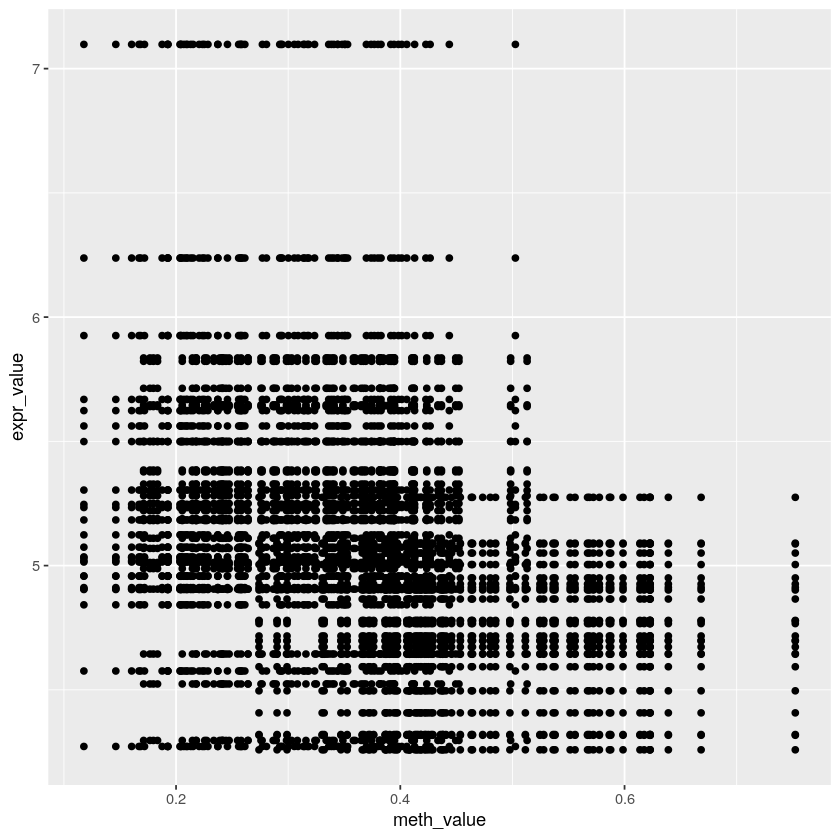

In [100]:
ggplot(cd4_correlation, aes(x=meth_value, y=expr_value)) + geom_point()


In [189]:
cd8_meth_genes <- gconvert(cd8_anno$UCSC_RefGene_Accession, target="ILLUMINA_HUMANHT_12_V4")$target
cd8_expr_genes <- cd8_expr_anno$ID
cd8_both <- intersect(cd8_meth_genes, cd8_expr_genes)
cd8_both
length(cd8_both)

[1] "ILMN_1712719" "ILMN_1748473" "ILMN_1783645" "ILMN_2414325" "ILMN_1799848"
 [6] "ILMN_2132599" "ILMN_1739454" "ILMN_3236866" "ILMN_1705183" "ILMN_1804170"
[11] "ILMN_1761921" "ILMN_2275399" "ILMN_1801246" "ILMN_1671678" "ILMN_3185278"
[16] "ILMN_1732926" "ILMN_1911196" "ILMN_3310890" "ILMN_1785141" "ILMN_1664410"
[21] "ILMN_1678145" "ILMN_3308148" "ILMN_1673330" "ILMN_3310426" "ILMN_2361324"
[26] "ILMN_1788531" "ILMN_1769433" "ILMN_1749269" "ILMN_1757827" "ILMN_1660541"
[31] "ILMN_1743290" "ILMN_1731049" "ILMN_1761262" "ILMN_1664691" "ILMN_1682495"
[36] "ILMN_1782230" "ILMN_2053992" "ILMN_1674838" "ILMN_1780898" "ILMN_1727288"
[41] "ILMN_1701248" "ILMN_1742001" "ILMN_1771695" "ILMN_1696702" "ILMN_2252495"
[46] "ILMN_1695418" "ILMN_1657891" "ILMN_1888609" "ILMN_2390609" "ILMN_1752668"
[51] "ILMN_1732049" "ILMN_1711681" "ILMN_2221066" "ILMN_1708130" "ILMN_1725427"
[56] "ILMN_2148459" "ILMN_1815205" "ILMN_2162972" "ILMN_1749629" "ILMN_1777017"
[61] "ILMN_1731231" "ILMN_1727602" "ILMN_1747744" "ILMN_1751656" "ILMN_1809259"
[66] "ILMN_1736836" "ILMN_1729487" "ILMN_2248863" "ILMN_1781381" "ILMN_1765872"
[71] "ILMN_3229324" "ILMN_3305938" "ILMN_1747223" "ILMN_1671933" "ILMN_1716264"
[76] "ILMN_1790555" "ILMN_1711102" "ILMN_2108699" "ILMN_1706957" "ILMN_1675848"

[1] 80